Veri başarıyla yüklendi.

 İlk 10 Satır:

 Güncellenmiş tablo:

 Eksik Değer Tablosu:

 Özellik Tablosu (İlk 5):

Eğitim veri boyutu: (15183, 12)
Test veri boyutu: (3796, 12)


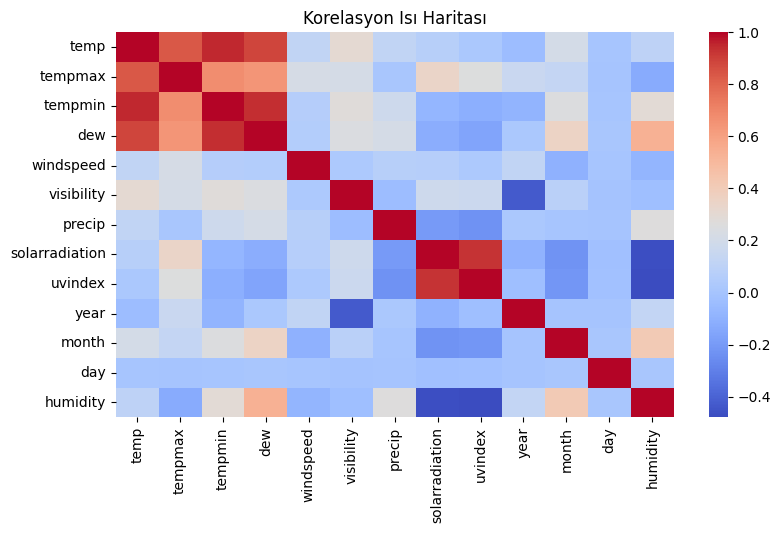


 MODEL SONUÇLARI
MAE: 0.8641747525457808
R²: 0.9781892749350534

 İlk 15 veri için Gerçek - Tahmin Tablosu :


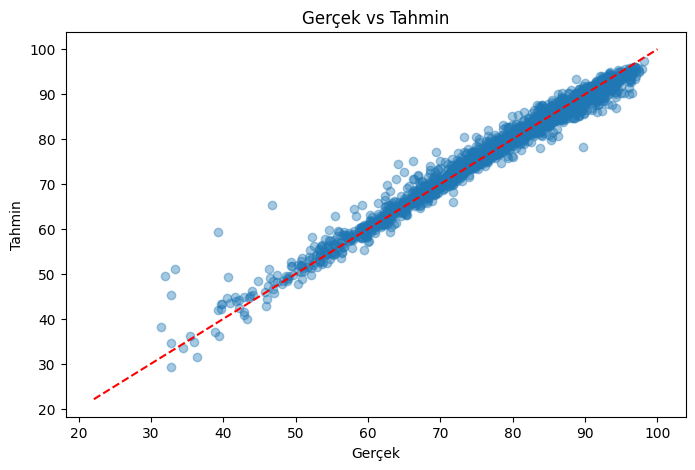


 Özellik Önem Tablosu:


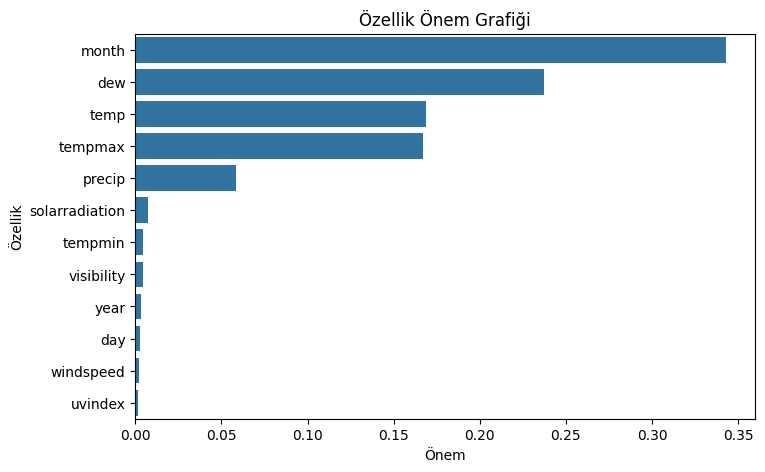


 Örnek Tahmin (Girdi Tablosu):

 Tahmin edilen nem: 70.32536331662642

 Model kayıt edildi: humidity_model.pkl


In [3]:


import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# veriyi uygun veri yolu ile yükleme
BASE_DIR = os.getcwd()
DATA_PATH = os.path.join(BASE_DIR, "data", "guwahati_weather_1972_2025.csv")

df = pd.read_csv(DATA_PATH)
print("Veri başarıyla yüklendi.")

# verideki ilk 10 satır çıktısı
print("\n İlk 10 Satır:")
df.head(10)

# tarih dönüşümü ve özellik ekleme
df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce")
df["year"] = df["datetime"].dt.year
df["month"] = df["datetime"].dt.month
df["day"] = df["datetime"].dt.day

print("\n Güncellenmiş tablo:")
df[["datetime","year","month","day"]].head()


# eksik veri tablosu
missing_table = df.isnull().sum().to_frame("Eksik Değer Sayısı")
print("\n Eksik Değer Tablosu:")
missing_table

# target yani tahmin edilecek değer ve features(özellikler)

TARGET = "humidity"
df = df.dropna(subset=[TARGET]).copy()

features = [
    "temp","tempmax","tempmin","dew",
    "windspeed","visibility","precip",
    "solarradiation","uvindex",
    "year","month","day"
]

X = df[features]
y = df[TARGET]

print("\n Özellik Tablosu (İlk 5):")
X.head()

# train ve test ayırma

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

print("\nEğitim veri boyutu:", X_train.shape)
print("Test veri boyutu:", X_test.shape)

# korelasyon ısı haritası için 
plt.figure(figsize=(9,5))
sns.heatmap(df[features + [TARGET]].corr(), cmap="coolwarm")
plt.title("Korelasyon Isı Haritası")
plt.show()

# model kurulumu

model = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("rf", RandomForestRegressor(
        n_estimators=200,
        max_depth=16,
        random_state=42
    ))
])

model.fit(X_train, y_train)

# performans ölçme ve değerlendirme

preds = model.predict(X_test)

mae = mean_absolute_error(y_test, preds)
r2 = r2_score(y_test, preds)

print("\n MODEL SONUÇLARI")
print("MAE:", mae)
print("R^2:", r2)

# gerçek ve vs tahmin tablosu

comparison = pd.DataFrame({
    "Gerçek": y_test.values[:15],
    "Tahmin": preds[:15]
})

print("\n İlk 15 veri için Gerçek - Tahmin Tablosu :")
comparison

# matplotlib ile grafik çizimi (GERÇEK vs TAHMİN)

plt.figure(figsize=(8,5))
plt.scatter(y_test, preds, alpha=0.4)
plt.plot([y.min(), y.max()], [y.min(), y.max()], "r--")
plt.xlabel("Gerçek")
plt.ylabel("Tahmin")
plt.title("Gerçek vs Tahmin")
plt.show()

# özellik önem tablosu

rf = model.named_steps["rf"]
importance_table = pd.DataFrame({
    "Özellik": features,
    "Önem": rf.feature_importances_
}).sort_values("Önem", ascending=False)

print("\n Özellik Önem Tablosu:")
importance_table

plt.figure(figsize=(8,5))
sns.barplot(data=importance_table, x="Önem", y="Özellik")
plt.title("Özellik Önem Grafiği")
plt.show()

# sample oluşturma

sample = pd.DataFrame({
    "temp":[25], "tempmax":[40], "tempmin":[50], "dew":[18.5],
    "windspeed":[50], "visibility":[8], "precip":[0.1],
    "solarradiation":[150], "uvindex":[6],
    "year":[2024], "month":[7], "day":[12]
})

sample = sample[X.columns]
print("\n Örnek Tahmin (Girdi Tablosu):")
sample

prediction = model.predict(sample)[0]
print("\n Tahmin edilen nem:", prediction)

#modeli kaydederek sonraki çalışmalar için kolaylık

import joblib
joblib.dump(model, "humidity_model.pkl")

print("\n Model kayıt edildi: humidity_model.pkl")
